# Задание


Применить различные методы машинного обучения, оценить их производительность и провести анализ результатов.

Вариант 2:
Загрузить временной ряд и создать модель регрессии для прогнозирования будущих значений.

# Описание и загрузка данных

Данные взяты с сайта https://www.meteoblue.com/ru, содержащего раздел "Загрузка данных", позволяющий скачать архивные метеорологические данные относительно города Базель:  https://www.meteoblue.com/ru/%D0%BF%D0%BE%D0%B3%D0%BE%D0%B4%D0%B0/archive/export

Позволяет установить настройки для формата данных и выбрать показатели.

*Базель — это город в Швейцарии, расположенный на северо-западе страны, на границе с Францией и Германией.


Для выполнения данной работы была сформирована выгрузка данных за период 01.01.2000 по 01.11.2024 в формате csv со следующими данными:

дата;

максимальная дневная температура по Цельсию на уровне 2 м от земли;

минимальная дневная температура по Цельсию на уровне 2 м от земли;

средняя дневная температура по Цельсию на уровне 2 м от земли;

общее дневное количество осадков в мм;

максимальный дневной порыв ветра в м/с;

минимальный дневной порыв ветра в м/с;

средний дневной порыв ветра в м/с;

средняя дневная облачность в %;

максимальное дневное давление в hpa;

минимальное дневное давление в hpa;

среднее дневное давление в hpa;

максимальная дневная температура по Цельсию у поверхности земли;

минимальная дневная температура по Цельсию у поверхности земли;

средняя дневная температура по Цельсию у поверхности земли.

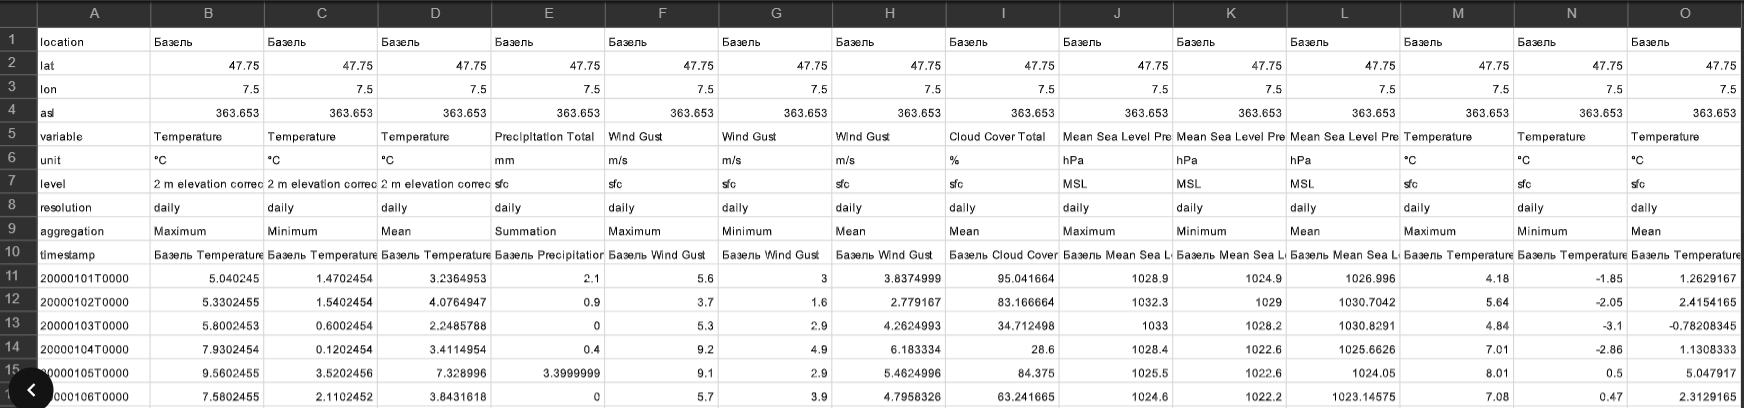

In [104]:
!pip install pmdarima

In [105]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.model_selection import TimeSeriesSplit, cross_val_score

In [106]:
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv('drive/MyDrive/DS_Belhard_2/Homeworks/HW_1/dataexport_20241102.csv')
print(data.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(9081, 15)


In [107]:
# Заголовки столбцов
data.columns

Index(['location', 'Базель', 'Базель.1', 'Базель.2', 'Базель.3', 'Базель.4',
       'Базель.5', 'Базель.6', 'Базель.7', 'Базель.8', 'Базель.9', 'Базель.10',
       'Базель.11', 'Базель.12', 'Базель.13'],
      dtype='object')

In [108]:
# Вывод первых 11 строк
data.head(11)

,location,Базель,Базель.1,Базель.2,Базель.3,Базель.4,Базель.5,Базель.6,Базель.7,Базель.8,Базель.9,Базель.10,Базель.11,Базель.12,Базель.13
0,lat,47.75000,47.75000,47.75000,47.75000,47.75000,47.75000,47.75000,47.75000,47.75000,47.75000,47.75000,47.75000,47.75000,47.75000
1,lon,7.50000,7.50000,7.50000,7.50000,7.50000,7.50000,7.50000,7.50000,7.50000,7.50000,7.50000,7.50000,7.50000,7.50000
2,asl,363.653,363.653,363.653,363.653,363.653,363.653,363.653,363.653,363.653,363.653,363.653,363.653,363.653,363.653
3,variable,Temperature,Temperature,Temperature,Precipitation Total,Wind Gust,Wind Gust,Wind Gust,Cloud Cover Total,Mean Sea Level Pressure,Mean Sea Level Pressure,Mean Sea Level Pressure,Temperature,Temperature,Temperature
4,unit,°C,°C,°C,mm,m/s,m/s,m/s,%,hPa,hPa,hPa,°C,°C,°C
5,level,2 m elevation corrected,2 m elevation corrected,2 m elevation corrected,sfc,sfc,sfc,sfc,sfc,MSL,MSL,MSL,sfc,sfc,sfc
6,resolution,daily,daily,daily,daily,daily,daily,daily,daily,daily,daily,daily,daily,daily,daily
7,aggregation,Maximum,Minimum,Mean,Summation,Maximum,Minimum,Mean,Mean,Maximum,Minimum,Mean,Maximum,Minimum,Mean
8,timestamp,Базель Temperature [2 m elevation corrected],Базель Temperature [2 m elevation corrected],Базель Temperature [2 m elevation corrected],Базель Precipitation Total,Базель Wind Gust,Базель Wind Gust,Базель Wind Gust,Базель Cloud Cover Total,Базель Mean Sea Level Pressure [MSL],Базель Mean Sea Level Pressure [MSL],Базель Mean Sea Level Pressure [MSL],Базель Temperature,Базель Temperature,Базель Temperature
9,20000101T0000,5.040245,1.4702454,3.2364953,2.1,5.6,3.0,3.8374999,95.041664,1028.9,1024.9,1026.996,4.18,-1.85,1.2629167


# Предобработка данных

В сформированном файле описание данных содержится в первых 9 строках, соответственно, потребуется преобработка заголовков столбцов

In [109]:
# Удаление первых 9 строк, так как в них содержится описание
data = data.iloc[9:]
data

,location,Базель,Базель.1,Базель.2,Базель.3,Базель.4,Базель.5,Базель.6,Базель.7,Базель.8,Базель.9,Базель.10,Базель.11,Базель.12,Базель.13
9,20000101T0000,5.040245,1.4702454,3.2364953,2.1,5.6,3.0,3.8374999,95.041664,1028.9,1024.9,1026.996,4.18,-1.85,1.2629167
10,20000102T0000,5.3302455,1.5402454,4.0764947,0.9,3.7,1.6,2.779167,83.166664,1032.3,1029.0,1030.7042,5.64,-2.05,2.4154165
11,20000103T0000,5.8002453,0.6002454,2.2485788,0.0,5.3,2.9,4.2624993,34.712498,1033.0,1028.2,1030.8291,4.84,-3.1,-0.78208345
12,20000104T0000,7.9302454,0.1202454,3.4114954,0.4,9.2,4.9,6.183334,28.6,1028.4,1022.6,1025.6626,7.01,-2.86,1.1308333
13,20000105T0000,9.5602455,3.5202456,7.328996,3.3999999,9.1,2.9,5.4624996,84.375,1025.5,1022.6,1024.05,8.01,0.5,5.047917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9076,20241028T0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9077,20241029T0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9078,20241030T0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9079,20241031T0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [110]:
# Новые имена столбцов
new_columns = [
    'year_month_day',
    'daily_max_temperatyre_2m_c',
    'daily_min_temperature_2m_c',
    'daily_mean_temperatyre_2m_c',
    'summ_daily_precipitation_mm',
    'daily_max_windgust_ms',
    'daily_min_windgust_ms',
    'daily_mean_windgust_ms',
    'daily_mean_cloudcover_%',
    'daily_max_pressure_hpa',
    'daily_min_pressure_hpa',
    'daily_mean_pressure_hpa',
    'daily_max_temperatyre_sfc_c',
    'daily_min_temperature_sfc_c',
    'daily_mean_temperatyre_sfc_c'
]

# Переименование столбцов
data.columns = new_columns

In [111]:
# Проверка результата
data

,year_month_day,daily_max_temperatyre_2m_c,daily_min_temperature_2m_c,daily_mean_temperatyre_2m_c,summ_daily_precipitation_mm,daily_max_windgust_ms,daily_min_windgust_ms,daily_mean_windgust_ms,daily_mean_cloudcover_%,daily_max_pressure_hpa,daily_min_pressure_hpa,daily_mean_pressure_hpa,daily_max_temperatyre_sfc_c,daily_min_temperature_sfc_c,daily_mean_temperatyre_sfc_c
9,20000101T0000,5.040245,1.4702454,3.2364953,2.1,5.6,3.0,3.8374999,95.041664,1028.9,1024.9,1026.996,4.18,-1.85,1.2629167
10,20000102T0000,5.3302455,1.5402454,4.0764947,0.9,3.7,1.6,2.779167,83.166664,1032.3,1029.0,1030.7042,5.64,-2.05,2.4154165
11,20000103T0000,5.8002453,0.6002454,2.2485788,0.0,5.3,2.9,4.2624993,34.712498,1033.0,1028.2,1030.8291,4.84,-3.1,-0.78208345
12,20000104T0000,7.9302454,0.1202454,3.4114954,0.4,9.2,4.9,6.183334,28.6,1028.4,1022.6,1025.6626,7.01,-2.86,1.1308333
13,20000105T0000,9.5602455,3.5202456,7.328996,3.3999999,9.1,2.9,5.4624996,84.375,1025.5,1022.6,1024.05,8.01,0.5,5.047917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9076,20241028T0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9077,20241029T0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9078,20241030T0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9079,20241031T0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [112]:
# Сброс индекса
data.reset_index(drop=True, inplace=True)

# Обрезка значений в первом столбце до первых 8 символов
data['year_month_day'] = data['year_month_day'].str[:8]

# Проверка результата
data

,year_month_day,daily_max_temperatyre_2m_c,daily_min_temperature_2m_c,daily_mean_temperatyre_2m_c,summ_daily_precipitation_mm,daily_max_windgust_ms,daily_min_windgust_ms,daily_mean_windgust_ms,daily_mean_cloudcover_%,daily_max_pressure_hpa,daily_min_pressure_hpa,daily_mean_pressure_hpa,daily_max_temperatyre_sfc_c,daily_min_temperature_sfc_c,daily_mean_temperatyre_sfc_c
0,20000101,5.040245,1.4702454,3.2364953,2.1,5.6,3.0,3.8374999,95.041664,1028.9,1024.9,1026.996,4.18,-1.85,1.2629167
1,20000102,5.3302455,1.5402454,4.0764947,0.9,3.7,1.6,2.779167,83.166664,1032.3,1029.0,1030.7042,5.64,-2.05,2.4154165
2,20000103,5.8002453,0.6002454,2.2485788,0.0,5.3,2.9,4.2624993,34.712498,1033.0,1028.2,1030.8291,4.84,-3.1,-0.78208345
3,20000104,7.9302454,0.1202454,3.4114954,0.4,9.2,4.9,6.183334,28.6,1028.4,1022.6,1025.6626,7.01,-2.86,1.1308333
4,20000105,9.5602455,3.5202456,7.328996,3.3999999,9.1,2.9,5.4624996,84.375,1025.5,1022.6,1024.05,8.01,0.5,5.047917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9067,20241028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9068,20241029,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9069,20241030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9070,20241031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [113]:
# Количество нулевых значений
null_counts = data.isnull().sum()

print(null_counts)

year_month_day                  0
daily_max_temperatyre_2m_c      7
daily_min_temperature_2m_c      7
daily_mean_temperatyre_2m_c     7
summ_daily_precipitation_mm     7
daily_max_windgust_ms           7
daily_min_windgust_ms           7
daily_mean_windgust_ms          7
daily_mean_cloudcover_%         7
daily_max_pressure_hpa          7
daily_min_pressure_hpa          7
daily_mean_pressure_hpa         7
daily_max_temperatyre_sfc_c     7
daily_min_temperature_sfc_c     7
daily_mean_temperatyre_sfc_c    7
dtype: int64


Есть предположение, что строки с нулевыми значениями будут последними в df. По результатам проверки ниже, так и окажется

In [114]:
# Вывод всех строк с нулевыми значениями в daily_mean_temperatyre_sfc_c
null_rows = data.loc[data['daily_mean_temperatyre_sfc_c'].isnull()]

#print(null_rows)

In [115]:
# Удаление последних 7 строк
data = data.drop(data.index[-7:])

# Количество нулевых значений
null_counts = data.isnull().sum()
print(null_counts)

year_month_day                  0
daily_max_temperatyre_2m_c      0
daily_min_temperature_2m_c      0
daily_mean_temperatyre_2m_c     0
summ_daily_precipitation_mm     0
daily_max_windgust_ms           0
daily_min_windgust_ms           0
daily_mean_windgust_ms          0
daily_mean_cloudcover_%         0
daily_max_pressure_hpa          0
daily_min_pressure_hpa          0
daily_mean_pressure_hpa         0
daily_max_temperatyre_sfc_c     0
daily_min_temperature_sfc_c     0
daily_mean_temperatyre_sfc_c    0
dtype: int64


In [116]:
data

,year_month_day,daily_max_temperatyre_2m_c,daily_min_temperature_2m_c,daily_mean_temperatyre_2m_c,summ_daily_precipitation_mm,daily_max_windgust_ms,daily_min_windgust_ms,daily_mean_windgust_ms,daily_mean_cloudcover_%,daily_max_pressure_hpa,daily_min_pressure_hpa,daily_mean_pressure_hpa,daily_max_temperatyre_sfc_c,daily_min_temperature_sfc_c,daily_mean_temperatyre_sfc_c
0,20000101,5.040245,1.4702454,3.2364953,2.1,5.6,3.0,3.8374999,95.041664,1028.9,1024.9,1026.996,4.18,-1.85,1.2629167
1,20000102,5.3302455,1.5402454,4.0764947,0.9,3.7,1.6,2.779167,83.166664,1032.3,1029.0,1030.7042,5.64,-2.05,2.4154165
2,20000103,5.8002453,0.6002454,2.2485788,0.0,5.3,2.9,4.2624993,34.712498,1033.0,1028.2,1030.8291,4.84,-3.1,-0.78208345
3,20000104,7.9302454,0.1202454,3.4114954,0.4,9.2,4.9,6.183334,28.6,1028.4,1022.6,1025.6626,7.01,-2.86,1.1308333
4,20000105,9.5602455,3.5202456,7.328996,3.3999999,9.1,2.9,5.4624996,84.375,1025.5,1022.6,1024.05,8.01,0.5,5.047917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9060,20241021,21.740246,9.680245,13.85733,0.0,4.5,1.9,3.7083333,27.324999,1027.3,1024.0,1025.904,20.76,8.13,12.819583
9061,20241022,17.560246,12.480246,15.509411,1.0,5.8,2.4,4.545834,79.96667,1031.8,1024.7,1028.046,15.64,10.81,13.184167
9062,20241023,15.900246,10.970245,13.073162,0.4,6.9,3.3,4.8500004,78.166664,1033.8,1030.2,1032.1084,15.64,9.49,12.091666
9063,20241024,17.620245,10.950245,13.311494,0.0,6.0,2.2,3.8291667,56.666668,1029.9,1023.3,1026.6,18.04,8.82,12.052083


In [117]:
print(data.dtypes)

year_month_day                  object
daily_max_temperatyre_2m_c      object
daily_min_temperature_2m_c      object
daily_mean_temperatyre_2m_c     object
summ_daily_precipitation_mm     object
daily_max_windgust_ms           object
daily_min_windgust_ms           object
daily_mean_windgust_ms          object
daily_mean_cloudcover_%         object
daily_max_pressure_hpa          object
daily_min_pressure_hpa          object
daily_mean_pressure_hpa         object
daily_max_temperatyre_sfc_c     object
daily_min_temperature_sfc_c     object
daily_mean_temperatyre_sfc_c    object
dtype: object


In [118]:
# Преобразование первого столбца в формат даты
data['year_month_day'] = pd.to_datetime(data['year_month_day'], format='%Y%m%d')

# Преобразование всех остальных столбцов в числовой тип данных
for column in data.columns[1:]:
    data[column] = pd.to_numeric(data[column], errors='coerce')

# Проверка типов данных после преобразования
print(data.dtypes)

year_month_day                  datetime64[ns]
daily_max_temperatyre_2m_c             float64
daily_min_temperature_2m_c             float64
daily_mean_temperatyre_2m_c            float64
summ_daily_precipitation_mm            float64
daily_max_windgust_ms                  float64
daily_min_windgust_ms                  float64
daily_mean_windgust_ms                 float64
daily_mean_cloudcover_%                float64
daily_max_pressure_hpa                 float64
daily_min_pressure_hpa                 float64
daily_mean_pressure_hpa                float64
daily_max_temperatyre_sfc_c            float64
daily_min_temperature_sfc_c            float64
daily_mean_temperatyre_sfc_c           float64
dtype: object


In [124]:
data_for_predict = data
# Пригодитс в конце работы для прогнозирования
# так как основной df data будет подлежать изменениям

In [95]:
# Анализ распределения данных
def analyze_distribution(df):
    # Определение числовых и категориальных признаков
    numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = df.select_dtypes(exclude=[np.number]).columns.tolist()

    print("Numerical features:", numerical_features)
    print("Categorical features:", categorical_features)

    if not numerical_features:
        raise ValueError("DataFrame does not contain numerical columns.")

    # Определение количества строк и столбцов для макета
    num_features = len(numerical_features)
    num_cols = 3
    num_rows = math.ceil(num_features / num_cols)

    # Гистограммы числовых признаков
    df[numerical_features].hist(bins=15, figsize=(15, 10), layout=(num_rows, num_cols))
    plt.suptitle('Histograms of Numerical Features')
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Добавление tight_layout для предотвращения наложения
    plt.show()

    # Линейные графики числовых признаков по year_month_day
    plt.figure(figsize=(15, 10))
    for i, feature in enumerate(numerical_features):
        if feature != 'year_month_day':
            plt.subplot(num_rows, num_cols, i + 1)
            plt.plot(df['year_month_day'], df[feature])
            plt.xlabel('year_month_day')
            plt.ylabel(feature)
            plt.title(f'Line Plot of {feature}')
    plt.suptitle('Line Plots of Numerical Features')
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    # Корреляционная тепловая карта
    plt.figure(figsize=(12, 8))
    corr_matrix = df[numerical_features].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Heatmap')
    plt.show()

    plt.show()

Numerical features: ['daily_max_temperatyre_2m_c', 'daily_min_temperature_2m_c', 'daily_mean_temperatyre_2m_c', 'summ_daily_precipitation_mm', 'daily_max_windgust_ms', 'daily_min_windgust_ms', 'daily_mean_windgust_ms', 'daily_mean_cloudcover_%', 'daily_max_pressure_hpa', 'daily_min_pressure_hpa', 'daily_mean_pressure_hpa', 'daily_max_temperatyre_sfc_c', 'daily_min_temperature_sfc_c', 'daily_mean_temperatyre_sfc_c']
Categorical features: ['year_month_day']


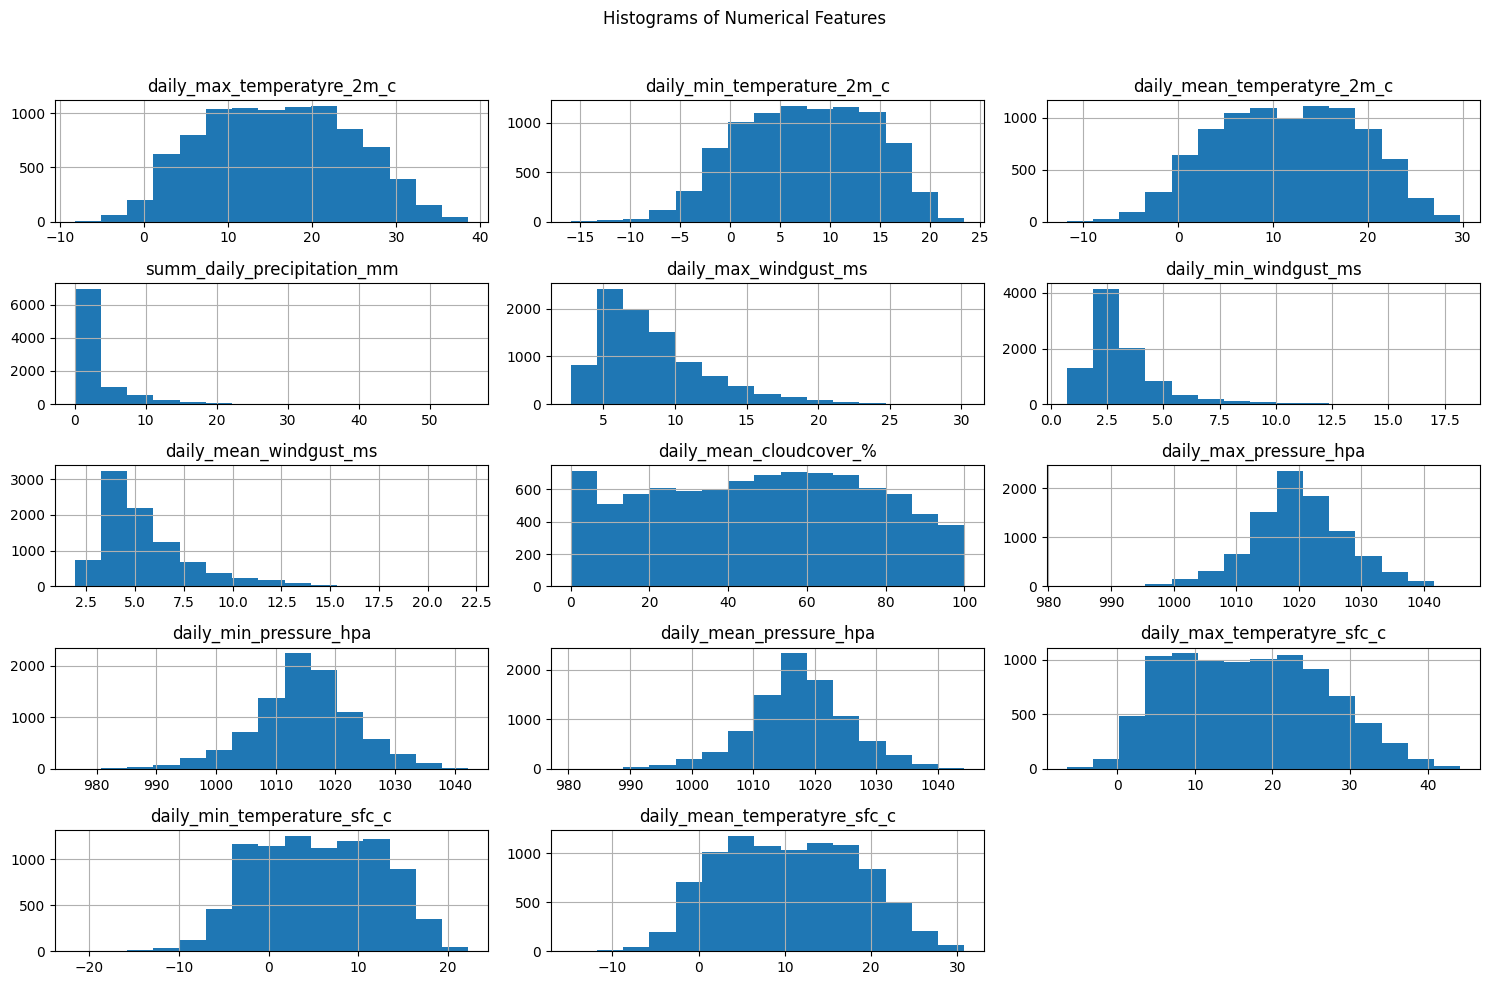

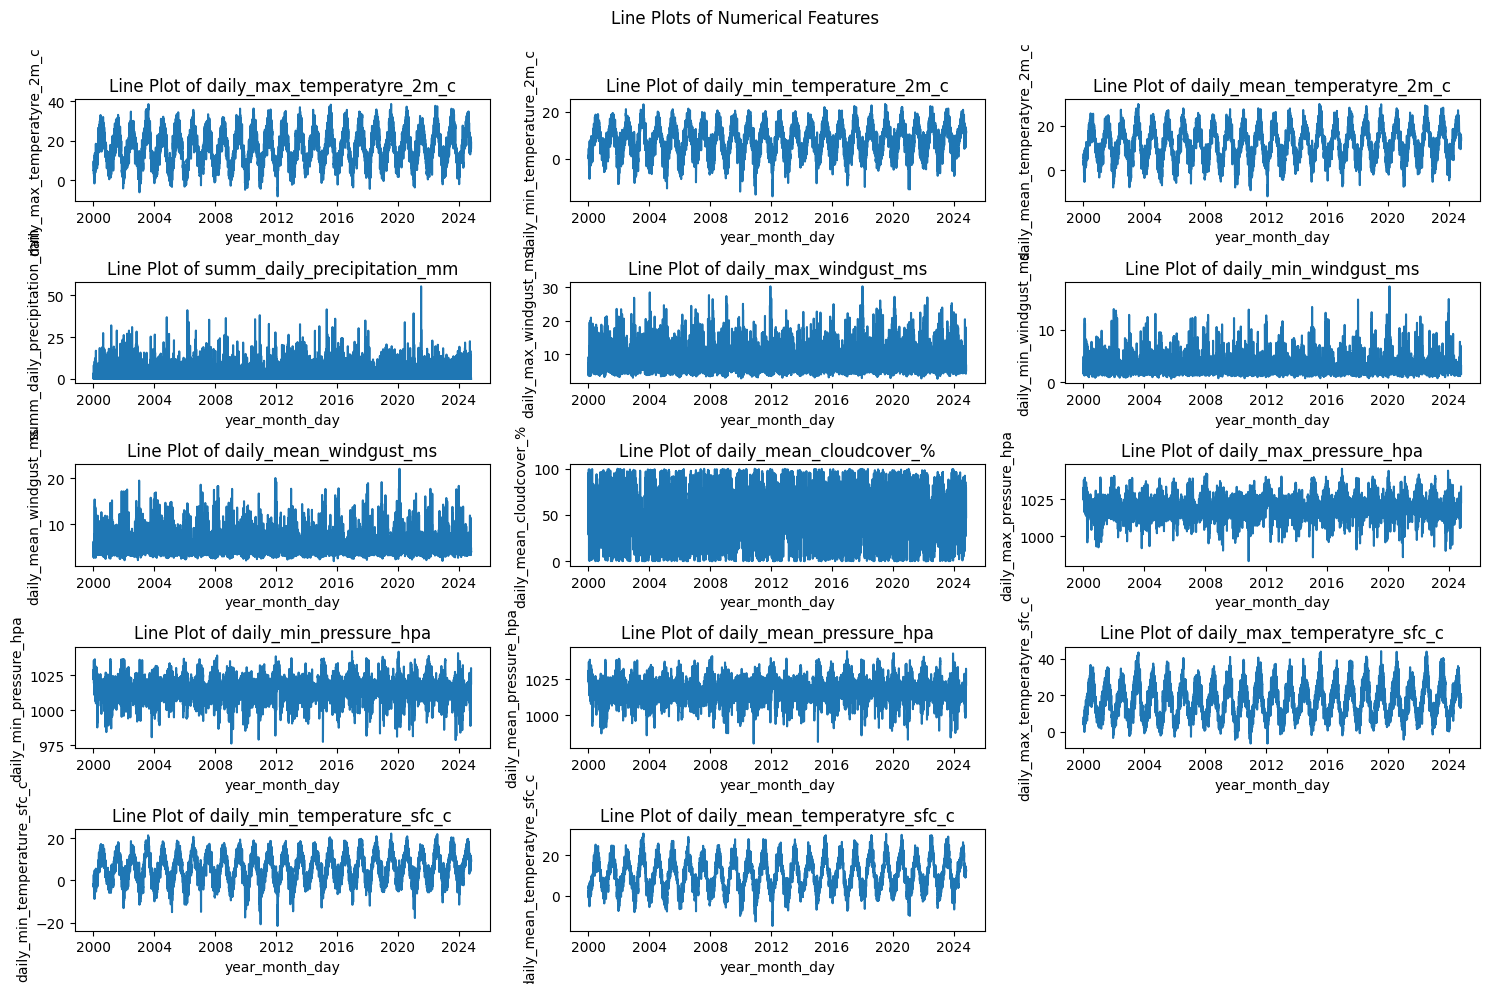

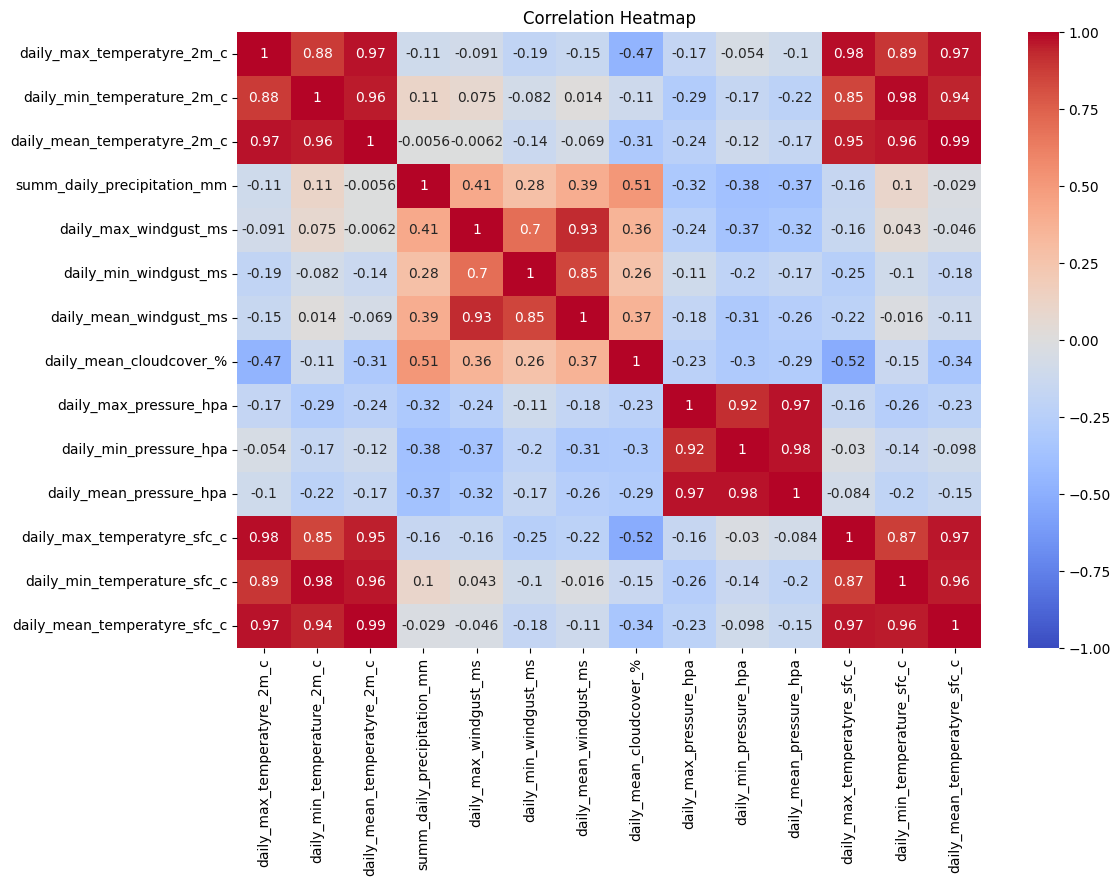

In [96]:
# Вызов функции
analyze_distribution(data)

# Моделирование

Рассматриваются следующие модели:


1.Множественная линейная регрессия для прогнозирования среднесуточной температуры на основе других признаков в наборе данных;


2.Декомпозиция временного ряда, разделяющая данные на три компонента: тренд (trend - долгосрочное направление изменения данных; сезонность (seasonal - повторяющиеся паттерны в данных, которые происходят с определенной периодичностью); остатки (residual - случайные колебания, которые не объясняются трендом или сезонностью).



3.ARIMA (AutoRegressive Integrated Moving Average), которая используется для анализа и прогнозирования временных рядов, не имеющих сезонных компонентов. Она включает три параметра:
p (AutoRegressive, AR) количество лагов в модели;
d (Integrated, I) порядок дифференцирования для стационарности;
q (Moving Average, MA) размер окна скользящего среднего.


4.SARIMA (Seasonal ARIMA), расширяющая ARIMA, путем добавления сезонной компоненты. Модель включает дополнительные параметры для учета сезонности:
P (Seasonal AR) количество сезонных лагов;
D (Seasonal I) порядок сезонного дифференцирования;
Q (Seasonal MA) размер окна сезонного скользящего среднего;
m период сезонности.


Основные отличия:
декомпозиция используется для анализа и визуализации компонентов временного ряда, но не для прогнозирования;
ARIMA подходит для временных рядов без сезонных паттернов;
SARIMA расширяет ARIMA для учета сезонных паттернов, что делает ее более подходящей для данных с выраженной сезонностью.

In [17]:
# Удаление столбца year_month_day
data = data.drop(columns=['year_month_day'])

Multiple Linear Regression - MSE: 0.09180212213055186, MAE: 0.21615475058507472, R²: 0.9983455936818945


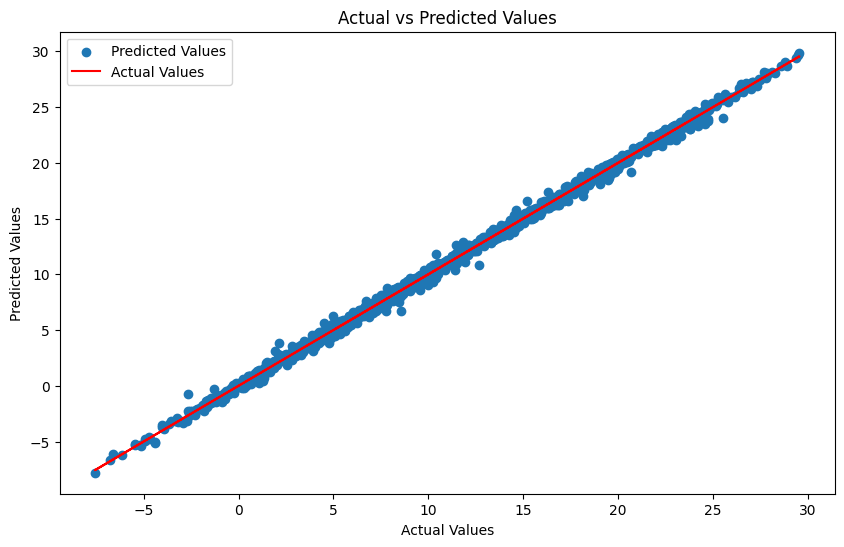

In [35]:
# Множественная линейная регрессия
def multiple_linear_regression(data):
    # Разделение данных на признаки и целевую переменную
    X = data.drop(columns=['daily_mean_temperatyre_2m_c'])
    y = data['daily_mean_temperatyre_2m_c']

    # Заполнение пропущенных значений
    imputer = SimpleImputer(strategy='mean')
    X = imputer.fit_transform(X)

    # Разделение данных на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Обучение модели множественной линейной регрессии
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Предсказание на тестовой выборке
    y_pred = model.predict(X_test)

    # Оценка модели множественной линейной регрессии
    mse_lr = mean_squared_error(y_test, y_pred)
    mae_lr = mean_absolute_error(y_test, y_pred)
    r2_lr = r2_score(y_test, y_pred)
    print(f'Multiple Linear Regression - MSE: {mse_lr}, MAE: {mae_lr}, R²: {r2_lr}')

    # Визуализация результатов
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, label='Predicted Values')
    plt.plot(y_test, y_test, color='red', label='Actual Values')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Values')
    plt.legend()
    plt.show()

    return mse_lr, mae_lr, r2_lr

# Использование функции
mse_lr, mae_lr, r2_lr = multiple_linear_regression(data)

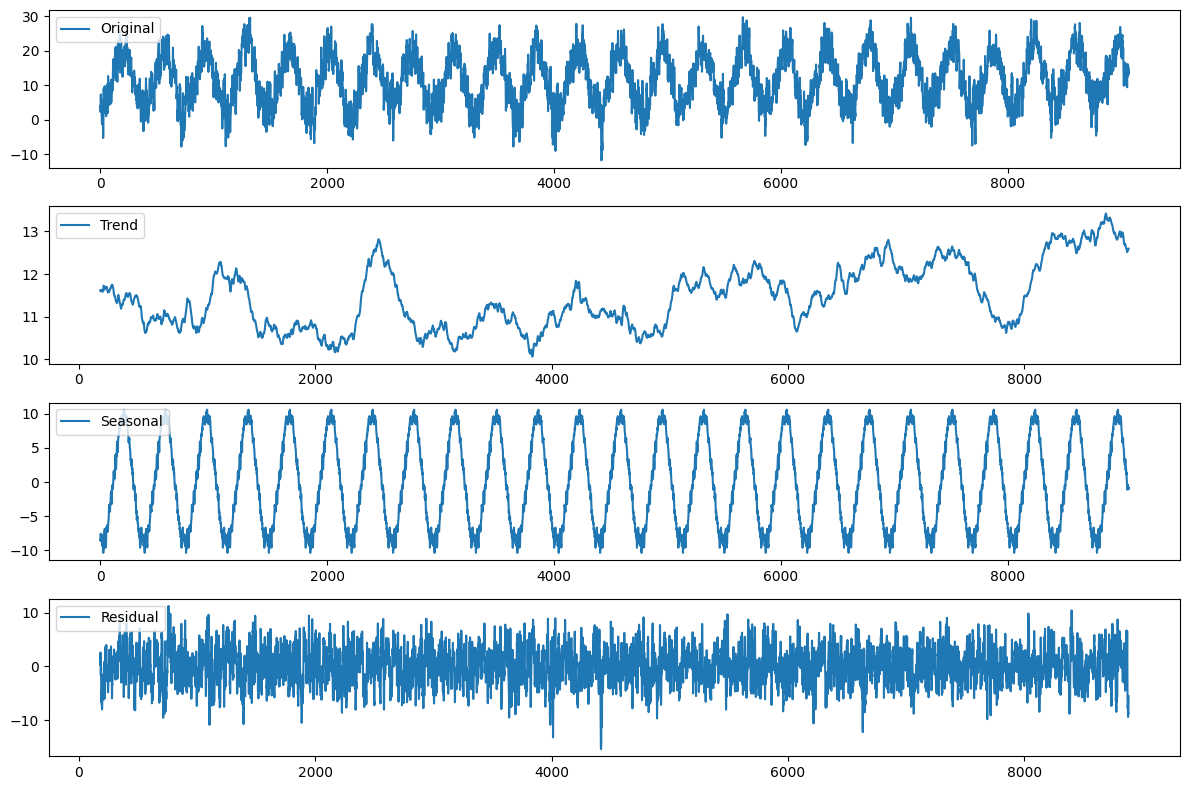

Decomposition Model - MSE: 8.013807699263162e-29, MAE: 7.251345401347641e-15, R²: 1.0


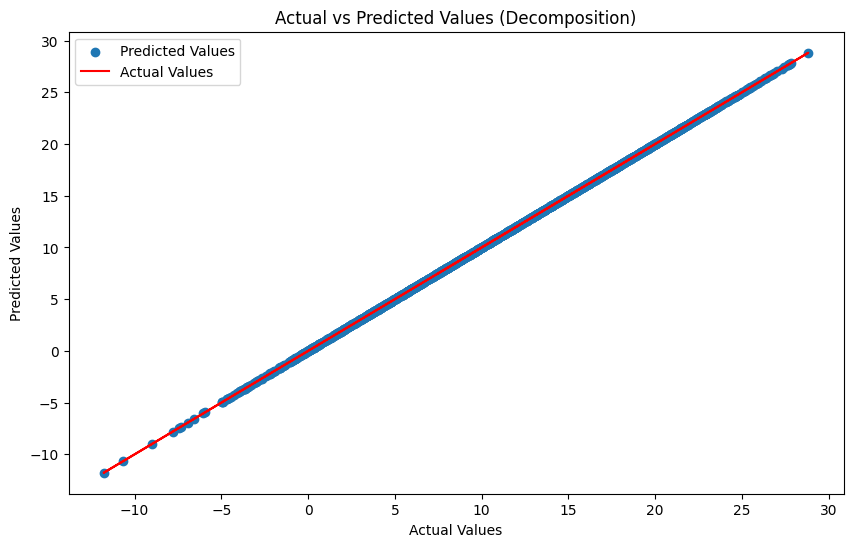

In [36]:
# Декомпозиция временного ряда
def decompose_time_series(data):
    period = 365
    result = seasonal_decompose(data['daily_mean_temperatyre_2m_c'], model='additive', period=period)
    data['trend'] = result.trend
    data['seasonal'] = result.seasonal
    data['residual'] = result.resid

    # Визуализация декомпозиции временного ряда
    plt.figure(figsize=(12, 8))
    plt.subplot(411)
    plt.plot(data['daily_mean_temperatyre_2m_c'], label='Original')
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(data['trend'], label='Trend')
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(data['seasonal'], label='Seasonal')
    plt.legend(loc='upper left')
    plt.subplot(414)
    plt.plot(data['residual'], label='Residual')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

    return data

def evaluate_decomposition(data):
    # Удаление строк с NaN значениями, которые появились после декомпозиции
    data = data.dropna()

    # Разделение данных
    X = data.drop(columns=['daily_mean_temperatyre_2m_c'])
    y = data['daily_mean_temperatyre_2m_c']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Множественная линейная регрессия для оценки декомпозиции
    dec_model = LinearRegression()
    dec_model.fit(X_train, y_train)
    y_pred_dec = dec_model.predict(X_test)

    # Оценка модели декомпозиции временного ряда
    mse_dec = mean_squared_error(y_test, y_pred_dec)
    mae_dec = mean_absolute_error(y_test, y_pred_dec)
    r2_dec = r2_score(y_test, y_pred_dec)
    print(f'Decomposition Model - MSE: {mse_dec}, MAE: {mae_dec}, R²: {r2_dec}')

    # Визуализация результатов декомпозиции временного ряда
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred_dec, label='Predicted Values')
    plt.plot(y_test, y_test, color='red', label='Actual Values')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Values (Decomposition)')
    plt.legend()
    plt.show()

    return mse_dec, mae_dec, r2_dec

# Пример использования функций
data = decompose_time_series(data)
mse_dec, mae_dec, r2_dec = evaluate_decomposition(data)

Прогнозирование производилось на основании всех трех компонентов: тренда, сезонности и остатка. Это позволяет учесть как долгосрочные изменения (тренд), так и регулярные колебания (сезонность), а также случайные колебания (остаток).

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=28924.586, Time=8.86 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=56026.649, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=29588.472, Time=0.16 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=47540.452, Time=0.83 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=29255.730, Time=1.41 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=29327.847, Time=1.83 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=28918.313, Time=1.70 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=28932.877, Time=3.27 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=inf, Time=9.65 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=28915.696, Time=5.74 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=28914.787, Time=7.39 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=29060.977, Time=1.82 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=28916.002, Time=4.91 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=28989.363, Time=2.68 sec
 ARIMA(3,0,4)(0,0,0)[0]  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ns will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ns will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ns will be used.
  self._init_dates(dates, freq)


ARIMA Model - MSE: 53.71583864099153, MAE: 6.139415799820192, R²: -0.010079227395699553


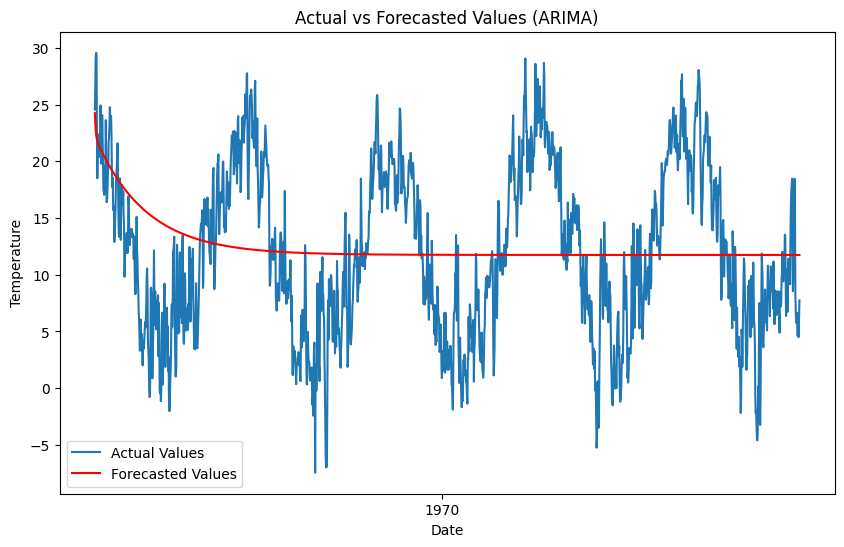

In [50]:
# Модель ARIMA
def evaluate_arima(data):
    # Удаление строк с NaN значениями
    data = data.dropna()

    # Убедимся, что индекс является DatetimeIndex
    if not isinstance(data.index, pd.DatetimeIndex):
        data.index = pd.to_datetime(data.index)

    # Разделение данных
    train_size = int(len(data) * 0.8)
    train, test = data[:train_size], data[train_size:]

    # Определение оптимальных параметров модели ARIMA
    auto_arima_model = auto_arima(train['daily_mean_temperatyre_2m_c'], seasonal= False, trace=True)
    order = auto_arima_model.order

    # Обучение модели ARIMA с оптимальными параметрами
    arima_model = ARIMA(train['daily_mean_temperatyre_2m_c'], order=order)
    arima_result = arima_model.fit()

    # Прогнозирование
    forecast = arima_result.forecast(steps=len(test))
    test = test.copy()  # Избегаем SettingWithCopyWarning
    test['forecast'] = forecast

    # Оценка модели ARIMA
    mse_arima = mean_squared_error(test['daily_mean_temperatyre_2m_c'], test['forecast'])
    mae_arima = mean_absolute_error(test['daily_mean_temperatyre_2m_c'], test['forecast'])
    r2_arima = r2_score(test['daily_mean_temperatyre_2m_c'], test['forecast'])
    print(f'ARIMA Model - MSE: {mse_arima}, MAE: {mae_arima}, R²: {r2_arima}')

    # Визуализация результатов модели ARIMA
    plt.figure(figsize=(10, 6))
    plt.plot(test['daily_mean_temperatyre_2m_c'], label='Actual Values')
    plt.plot(test['forecast'], label='Forecasted Values', color='red')
    plt.xlabel('Date')
    plt.ylabel('Temperature')
    plt.title('Actual vs Forecasted Values (ARIMA)')
    plt.legend()
    plt.show()

    return mse_arima, mae_arima, r2_arima

# Пример использования функций
mse_arima, mae_arima, r2_arima = evaluate_arima(data)

В контексте ARIMA-моделей, intercept (перехват) относится к константному члену в модели. Это значение, которое добавляется к прогнозируемому значению, если все другие параметры равны нулю. Включение перехвата может улучшить точность модели, особенно если данные имеют ненулевое среднее значение.

В вашем присутствуют результаты с перехватом и без него. С перехватом имеют более низкие значения AIC (критерий Акаике), что указывает на отработку модели с точки зрения баланса между сложностью модели и её точностью

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=28906.439, Time=50.44 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=47805.033, Time=0.51 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=29496.544, Time=11.88 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=37643.648, Time=6.66 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=56026.649, Time=0.13 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=28905.543, Time=30.57 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=28905.458, Time=12.21 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=28905.543, Time=53.56 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=29168.765, Time=7.03 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=29212.986, Time=5.97 sec
 ARIMA(3,0,2)(0,0,0)[12] intercept   : AIC=28896.998, Time=14.79 sec
 ARIMA(3,0,2)(1,0,0)[12] intercept   : AIC=28897.850, Time=48.64 sec
 ARIMA(3,0,2)(0,0,1)[12] intercept   : AIC=28897.847, Time=37.00 sec
 ARIMA(3,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=70.92 sec
 A

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ns will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ns will be used.
  self._init_dates(dates, freq)


SARIMA Model - MSE: 109.95374795841755, MAE: 8.561071269803046, R²: -1.06758378156171


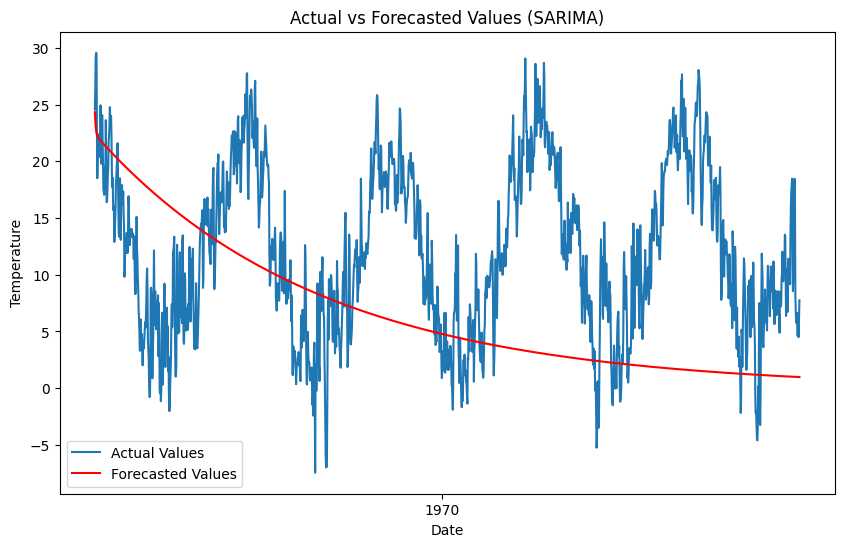

In [28]:
# Модель SARIMA
def evaluate_sarima(data):
    # Удаление строк с NaN значениями
    data = data.dropna()

    # Убедимся, что индекс является DatetimeIndex
    if not isinstance(data.index, pd.DatetimeIndex):
        data.index = pd.to_datetime(data.index)

    # Разделение данных
    train_size = int(len(data) * 0.8)
    train, test = data[:train_size], data[train_size:]

    # Определение оптимальных параметров модели SARIMA
    auto_sarima_model = auto_arima(train['daily_mean_temperatyre_2m_c'], seasonal=True, m=12, trace=True)
    order = auto_sarima_model.order
    seasonal_order = auto_sarima_model.seasonal_order

    # Обучение модели SARIMA с оптимальными параметрами
    sarima_model = SARIMAX(train['daily_mean_temperatyre_2m_c'], order=order, seasonal_order=seasonal_order)
    sarima_result = sarima_model.fit()

    # Прогнозирование
    forecast = sarima_result.get_forecast(steps=len(test)).predicted_mean
    test = test.copy()  # Избегаем SettingWithCopyWarning
    test['forecast'] = forecast

    # Оценка модели SARIMA
    mse_sarima = mean_squared_error(test['daily_mean_temperatyre_2m_c'], test['forecast'])
    mae_sarima = mean_absolute_error(test['daily_mean_temperatyre_2m_c'], test['forecast'])
    r2_sarima = r2_score(test['daily_mean_temperatyre_2m_c'], test['forecast'])
    print(f'SARIMA Model - MSE: {mse_sarima}, MAE: {mae_sarima}, R²: {r2_sarima}')

    # Визуализация результатов модели SARIMA
    plt.figure(figsize=(10, 6))
    plt.plot(test['daily_mean_temperatyre_2m_c'], label='Actual Values')
    plt.plot(test['forecast'], label='Forecasted Values', color='red')
    plt.xlabel('Date')
    plt.ylabel('Temperature')
    plt.title('Actual vs Forecasted Values (SARIMA)')
    plt.legend()
    plt.show()

    return mse_sarima, mae_sarima, r2_sarima

# Пример использования функций
mse_sarima, mae_sarima, r2_sarima = evaluate_sarima(data)

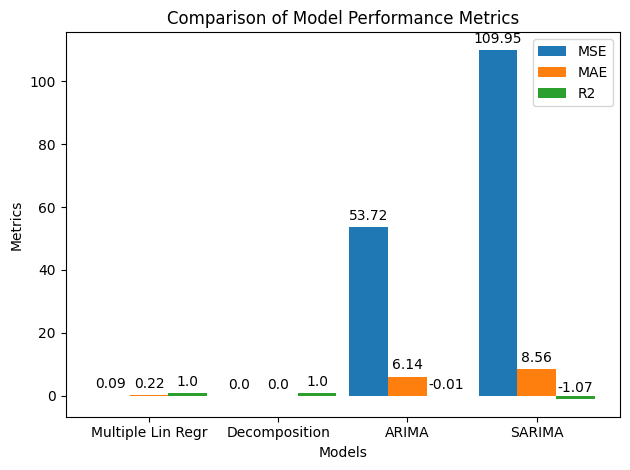

In [52]:
# Данные метрик моделей
models = ['Multiple Lin Regr', 'Decomposition', 'ARIMA', 'SARIMA']
mse = [mse_lr, mse_dec, mse_arima, mse_sarima]
mae = [mae_lr, mae_dec, mae_arima, mae_sarima]
r2 = [r2_lr, r2_dec, r2_arima, r2_sarima]

# Параметры для построения результирующего графика
x = np.arange(len(models))
width = 0.3

# Построение результирующего графика
fig, ax = plt.subplots()
rects1 = ax.bar(x - width, mse, width, label='MSE')
rects2 = ax.bar(x, mae, width, label='MAE')
rects3 = ax.bar(x + width, r2, width, label='R2')

# Добавление подписей и заголовков
ax.set_xlabel('Models')
ax.set_ylabel('Metrics')
ax.set_title('Comparison of Model Performance Metrics')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Функция для добавления значений на столбцы
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0,3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()
plt.show()

# Вывод

На основании метрик четырех моделей, Decomposition Model показывает наилучшие результаты. Decomposition Model имеет наименьшие значения MSE и MAE, а также наивысшее значение R², что указывает на отличное соответствие модели данным.

Однако, такие идеальные результаты могут быть следствием переобучения модели.
Для эксперимента будет использована кросс-валидация для более надежной оценки

In [55]:
def evaluate_decomposition(data):
    # Удаление строк с NaN значениями, которые появились после декомпозиции
    data = data.dropna()

    # Разделение данных
    X = data.drop(columns=['daily_mean_temperatyre_2m_c'])
    y = data['daily_mean_temperatyre_2m_c']

    # Кросс-валидация с TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=5)
    dec_model = LinearRegression()

    mse_scores = []
    mae_scores = []
    r2_scores = []

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        dec_model.fit(X_train, y_train)
        y_pred_dec = dec_model.predict(X_test)

        mse_scores.append(mean_squared_error(y_test, y_pred_dec))
        mae_scores.append(mean_absolute_error(y_test, y_pred_dec))
        r2_scores.append(r2_score(y_test, y_pred_dec))

    print(f'Decomposition Model - Cross-Validated MSE: {np.mean(mse_scores)}, MAE: {np.mean(mae_scores)}, R²: {np.mean(r2_scores)}')

    return np.mean(mse_scores), np.mean(mae_scores), np.mean(r2_scores)

# Пример использования функции
mse_dec, mae_dec, r2_dec = evaluate_decomposition(data)

Decomposition Model - Cross-Validated MSE: 1.2325893645572276e-28, MAE: 8.551419689699023e-15, R²: 1.0


Метрики указывают на то, что модель отлично справляется с прогнозированием на всех фолдах кросс-валидации, что подтверждает отсутствие переобучения

# Прогнозирование

Построение прогнозов для последующих значений с использованием наилучшей модели:

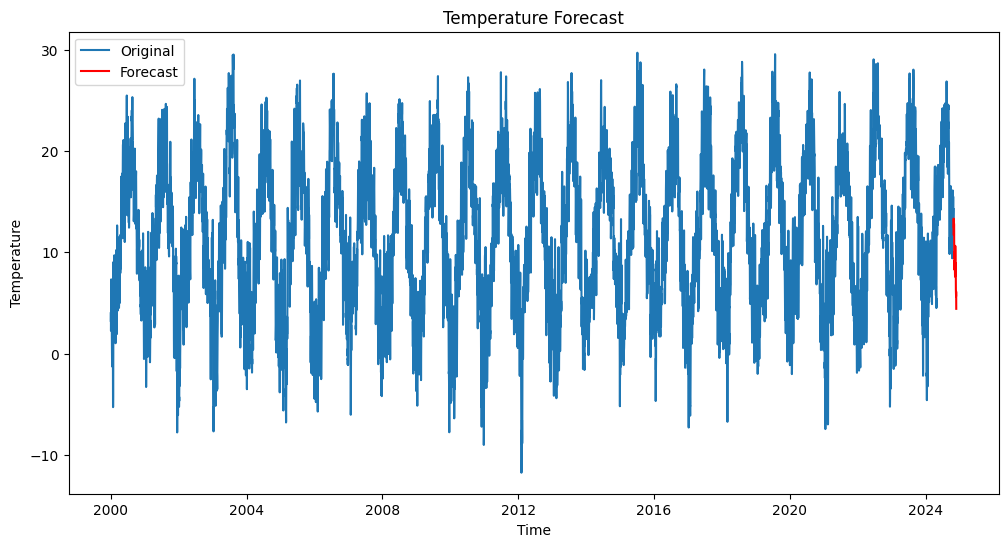

        Date   Forecast
0   20241026  11.775409
1   20241027  13.334342
2   20241028  13.120302
3   20241029  12.632905
4   20241030  12.414948
5   20241031  12.847841
6   20241101  12.624421
7   20241102  10.296895
8   20241103   9.438155
9   20241104  10.054779
10  20241105   8.275622
11  20241106   8.939831
12  20241107   9.235592
13  20241108   9.085489
14  20241109   8.873647
15  20241110   8.062998
16  20241111   7.590789
17  20241112   9.657169
18  20241113  10.642909
19  20241114  10.580177
20  20241115  10.194563
21  20241116   9.574472
22  20241117   7.823065
23  20241118   8.920976
24  20241119   8.017918
25  20241120   6.310273
26  20241121   5.963339
27  20241122   5.642488
28  20241123   6.122310
29  20241124   4.419086


In [128]:
# Функция для декомпозиции временного ряда
def decompose_time_series(data):
    period = 365
    result = seasonal_decompose(data['daily_mean_temperatyre_2m_c'], model='additive', period=period)
    data['trend'] = result.trend
    data['seasonal'] = result.seasonal
    data['residual'] = result.resid
    return data, result

# Функция для прогнозирования тренда
def forecast_trend(trend, periods):
    trend = trend.dropna()
    X = np.arange(len(trend)).reshape(-1, 1)
    y = trend.values
    model = LinearRegression()
    model.fit(X, y)
    future_X = np.arange(len(trend), len(trend) + periods).reshape(-1, 1)
    future_trend = model.predict(future_X)
    return future_trend

# Убедитесь, что данные начинаются с 01.01.2020
data_for_predict = data_for_predict[data_for_predict.index >= '2020-01-01']

data_for_predict, result = decompose_time_series(data_for_predict)

# Прогнозирование на следующие 30 дней
future_periods = 30
future_trend = forecast_trend(data_for_predict['trend'], future_periods)

# Добавление сезонной компоненты и остатка
last_seasonal = data_for_predict['seasonal'].iloc[-365:]  # Последний год сезонности
future_seasonal = np.tile(last_seasonal, int(np.ceil(future_periods / 365)))[:future_periods]
future_residual = np.zeros(future_periods)  # Предполагаем, что остаток равен нулю

# Итоговый прогноз
future_forecast = future_trend + future_seasonal + future_residual

# Создание DataFrame с предсказанными значениями
start_date = pd.to_datetime('2024-10-26')
forecast_dates = pd.date_range(start=start_date, periods=future_periods, freq='D')
forecast_df = pd.DataFrame({'Date': forecast_dates.strftime('%Y%m%d'), 'Forecast': future_forecast})

# Визуализация прогноза
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['daily_mean_temperatyre_2m_c'], label='Original')
plt.plot(forecast_dates, future_forecast, label='Forecast', color='red')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Temperature Forecast')
plt.legend()
plt.show()

# Вывод предсказанных значений
print(forecast_df)